In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
em_client = EMClient()
ophys_client = OPhysClient("/Users/chase/Desktop/test_v1dd_data")

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:24: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [3]:
em_client.get_tables()

['functional_coregistration_v1',
 'manual_pilot_functional_coregistration_v1',
 'correspondance_pilot',
 'ariadne_multisoma_proofreading_v1',
 'ariadne_dendrite_proofreading_v2',
 'ariadne_axon_proofreading_v1',
 'synapses_v1dd',
 'multisoma_split_task',
 'ariadne_dendrite_task',
 'ophys_examples',
 'manual_central_types',
 'nucleus_detection_v0',
 'ariadne_axon_task']

In [30]:
coreg = em_client.get_coregistration_table()
coreg.head()

,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,...,bb_end_position,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,1,2023-02-14 16:50:14.491563+00:00,t,277703,1,3,14,2,NaN,NaN,...,"[799901, 612885, 29027]",M409828_13,3,14,M409828_13_3_14,"[797.7329658575621, 268.4703958902916, 92.8290...",submitted,True,not_started,True
1,2,2023-02-14 16:50:14.492369+00:00,t,277515,1,3,60,0,NaN,NaN,...,"[840253, 582931, 28368]",M409828_13,1,60,M409828_13_1_60,"[838.0087061146714, 237.58057806602417, 93.975...",submitted,True,not_started,True
2,3,2023-02-14 16:50:14.493215+00:00,t,277213,1,3,30,1,NaN,NaN,...,"[791287, 598451, 26699]",M409828_13,2,30,M409828_13_2_30,"[790.0267659909371, 248.15872319569212, 76.111...",submitted,True,not_started,True
3,4,2023-02-14 16:50:14.494034+00:00,t,293528,1,3,119,4,NaN,NaN,...,"[764515, 637174, 26753]",M409828_13,5,119,M409828_13_5_119,"[763.2087486129211, 285.7899063229709, 65.5534...",submitted,True,submitted,True
4,5,2023-02-14 16:50:14.494820+00:00,t,277969,1,3,271,1,NaN,NaN,...,"[817050, 601866, 29619]",M409828_13,2,271,M409828_13_2_271,"[815.9190761795869, 258.40239635218177, 100.69...",submitted,True,not_started,True


In [31]:
# Load the corresponding 2P positions
coreg["ophys_pos"] = None

for idx, row in tqdm(coreg.iterrows(), total=len(coreg)):
    session = ophys_client.load_ophys_session(session_id=row.ophys_session_id)
    depth = session.get_plane_depth(plane=row.ophys_plane)
    y, x = np.mean(np.where(session.get_roi_image_mask(plane=row.ophys_plane, roi=row.ophys_roi)), axis=1) # note this is transposed
    coreg.at[idx, "ophys_pos"] = np.array([x, depth, y])

  0%|          | 0/51 [00:00<?, ?it/s]

(751.9179511334743, 939.4024606452016, -15.57742488917232, 171.42593037503343)

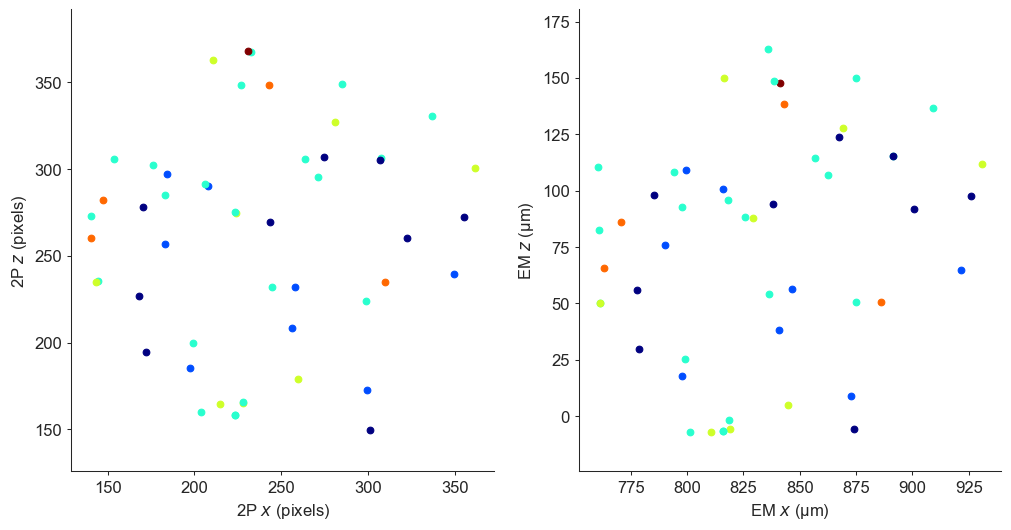

In [32]:
coreg_pts_microns = np.vstack(coreg.position_microns.values)
coreg_pts_ophys = np.vstack(coreg.ophys_pos.values)

fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].set_xlabel("2P $x$ (pixels)")
axs[0].set_ylabel("2P $z$ (pixels)")
axs[1].set_xlabel("EM $x$ (µm)")
axs[1].set_ylabel("EM $z$ (µm)")

cmap = plt.get_cmap("jet")
cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    color = cmap(cmap_norm(coreg_pts_ophys[i, 1])) # scatter.get_facecolors()[0]

    axs[0].scatter(coreg_pts_ophys[i, 0], coreg_pts_ophys[i, 2], color=color)
    axs[1].scatter(coreg_pts_microns[i, 0], coreg_pts_microns[i, 2], color=color)

axs[0].axis("equal")
axs[1].axis("equal")

# fig.colorbar(axs[1])

# Fit a transformation going from 2P space to EM space
Let P be the matrix of all 2P locations, with rows (2P x, 2P depth, 2P z). Similarly let C be the matrix of EM "cortical" locations with rows (EM x, EM depth, EM z).

We aim to find 3x3 matrix X that minimizes PX = C. The corresponding normal equation is P'PX = P'C.

We also add a bias term to offset

array([2, 6, 8, 1, 7, 0, 9, 4, 3, 5])

In [67]:
P = np.column_stack((coreg_pts_ophys, np.ones(len(coreg_pts_microns))))
C = coreg_pts_microns

np.random.seed(123)
n = len(P)
n_train = int(n * 0.75)
# n_train = n-5
rand_idx = np.random.permutation(n)

P_train, P_test = P[:n_train], P[n_train:]
C_train, C_test = C[:n_train], C[n_train:]

X = np.linalg.solve(np.matmul(P_train.T, P_train), np.matmul(P_train.T, C_train))
X

array([[ 7.61265443e-01,  6.13072366e-02,  3.16905800e-02],
       [-1.01403779e-02,  8.06523120e-01, -2.41638167e-01],
       [ 6.83572631e-02, -1.28870927e-02,  8.08945337e-01],
       [ 6.37869076e+02,  3.36546927e+01, -7.60159004e+01]])

In [1]:
fig, ax = plt.subplots(figsize=(4, 6))

ax.imshow(X, cmap="hot_r", vmin=0, vmax=0) # make everything white

row_labels = ["2P X", "2P Depth", "2P Z", "Bias"]
col_labels = ["EM X", "EM Depth", "EM Z"]

ax.set_xticks(np.arange(len(col_labels)), labels=col_labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(np.arange(len(row_labels)), labels=row_labels)

# Loop over data dimensions and create text annotations.
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        text = ax.text(j, i, f"{X[i, j]:.2e}", fontsize=14, ha="center", va="center", color="black")

ax.set_title("2P$\\rightarrow$EM linear transformation weights")
fig.tight_layout()

NameError: name 'plt' is not defined

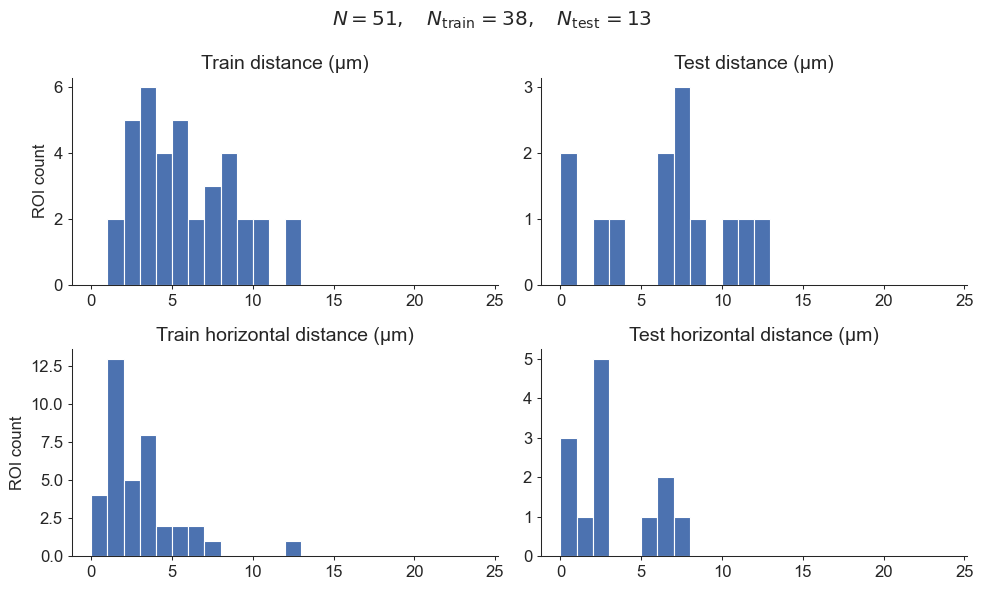

In [80]:
# Compute distance errors in microns
delta_microns = []
delta_microns_horiz = []
for i in range(n):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns.append(np.linalg.norm(ci_true - ci_pred))
    delta_microns_horiz.append(np.linalg.norm(ci_true[::2] - ci_pred[::2]))

fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
bins = np.arange(0, int(np.max(delta_microns))+1)

axs[0, 0].hist(delta_microns[:n_train], bins=bins)
axs[0, 0].set_title("Train distance (µm)")
axs[0, 0].set_ylabel("ROI count")
axs[0, 1].hist(delta_microns[n_train:], bins=bins)
axs[0, 1].set_title("Test distance (µm)")

axs[1, 0].hist(delta_microns_horiz[:n_train], bins=bins)
axs[1, 0].set_title("Train horizontal distance (µm)")
axs[1, 0].set_ylabel("ROI count")
axs[1, 1].hist(delta_microns_horiz[n_train:], bins=bins)
axs[1, 1].set_title("Test horizontal distance (µm)")

fig.suptitle(f"$N = {n}, \quad N_\\operatorname{{train}} = {n_train}, \quad N_\\operatorname{{test}} = {n-n_train}$")
fig.tight_layout()

(751.0910512750941, 939.3560007834598, -15.40170488924208, 170.97607456665256)

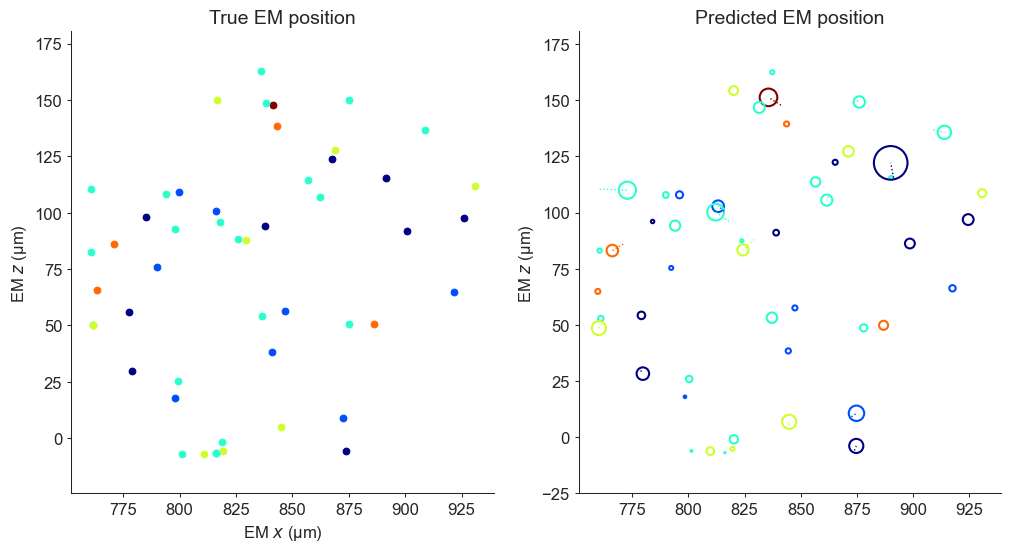

In [70]:
# Width (not area) of point is proportional to the prediction error in microns
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
# axs[0].set_xlabel("True EM $x$ (µm)")
# axs[0].set_ylabel("True EM $z$ (µm)")
# axs[1].set_xlabel("Predicted EM $x$ (µm)")
# axs[1].set_ylabel("Predicted EM $z$ (µm)")
axs[0].set_xlabel("EM $x$ (µm)")
axs[0].set_ylabel("EM $z$ (µm)")
axs[1].set_ylabel("EM $z$ (µm)")
axs[0].set_title("True EM position")
axs[1].set_title("Predicted EM position")

cmap = plt.get_cmap("jet")
cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns = np.linalg.norm(ci_true - ci_pred)
    color = cmap(cmap_norm(pi[1]))

    axs[0].scatter(ci_true[0], ci_true[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color, s=delta_microns**2)
    axs[1].scatter(ci_pred[0], ci_pred[2], color="none", edgecolor=color, linewidth=1.5, s=delta_microns**2)
    if delta_microns > 8:
        axs[1].plot([ci_true[0], ci_pred[0]], [ci_true[2], ci_pred[2]], color=color, linestyle="dotted", linewidth=1)

axs[0].axis("equal")
axs[1].axis("equal")



(751.9007111151928, 939.76450102911, -15.57742488917232, 171.42593037503343)

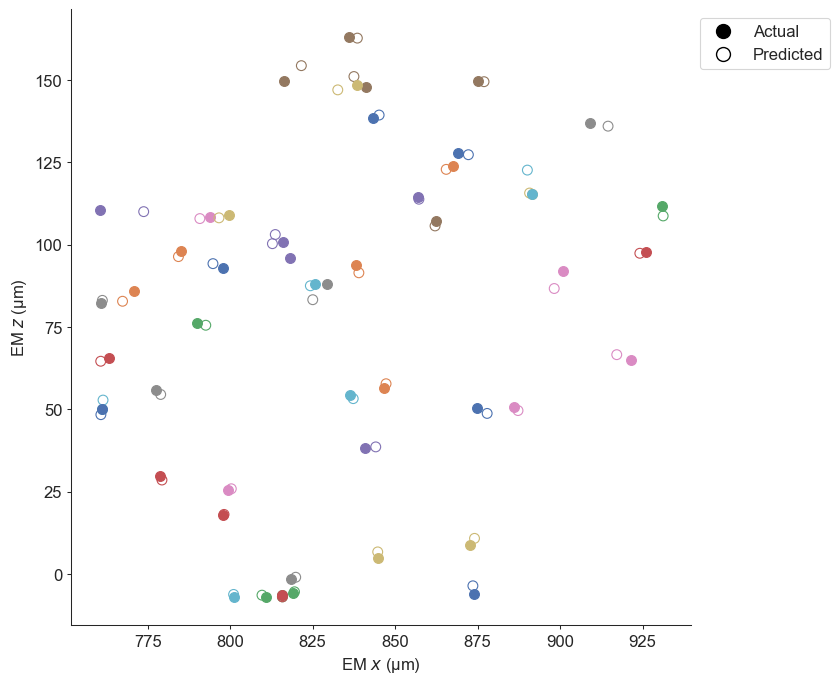

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel("EM $x$ (µm)")
ax.set_ylabel("EM $z$ (µm)")

# cmap = plt.get_cmap("jet")
# cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns = np.linalg.norm(ci_true - ci_pred)
    color = cmap(cmap_norm(pi[1]))

    color = ax.scatter(ci_true[0], ci_true[2], s=50).get_facecolors()[0]
    ax.scatter(ci_pred[0], ci_pred[2], facecolors="none", edgecolors=color, s=50)

    # axs[0].scatter(ci_true[0], ci_true[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color, s=delta_microns**2)

ax.legend(handles=[
    mpl.lines.Line2D([0], [0], label="Actual", marker="o", color="none", markerfacecolor="black", markersize=10),
    mpl.lines.Line2D([0], [0], label="Predicted", marker="o", color="none", markeredgecolor="black", markersize=10)
], loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
ax.axis("equal")

# Plot column boundaries in EM (from Marc Takeno)

In [16]:
EM_CENTER = (212574, 5674)
EM_COLUMN_BOUNDS = {
	1: ((256581, 9733), (160660, 1772)),
	2: ((212015, 5637), (117303, 14196)),
	3: ((212574, 5674), (120280, -20)),
	4: ((212574, 5674), (305983, 14382)),
	5: ((212574, 5674), (303751, 129))
}

# Transform according to scale
for col, (bound_1, bound_2) in EM_COLUMN_BOUNDS.keys():
    EM_COLUMN_BOUNDS[key] = (())

COLUMN_COLORS = {
    1: 'r',
    2: 'g',
    3: 'b',
    4: 'm',
    5: 'k'
}

# (212574, 89829, 5674)				center
# (117675, 89829, 14270)				column 2 outside corner
# (213132, 89829, 14308)				column 2 - 4 common corner
# (119908, 89829, 5562)				column 2 - 3 common corner
# (305983, 89829, 14382)				column 4 outside corner
# (304123, 89829, 5748)				column 4 - 5 common corner

<AxesSubplot: >

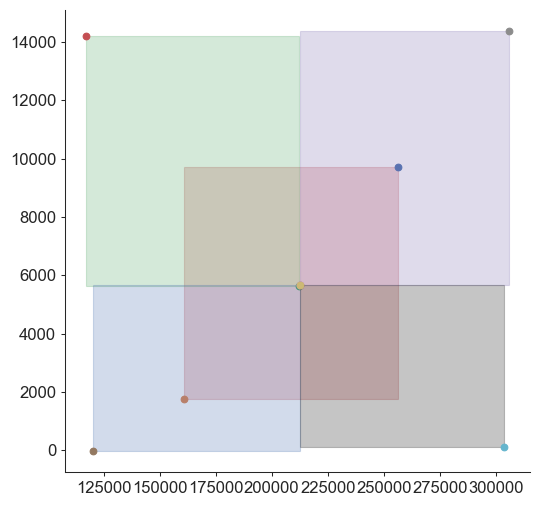

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

for col, (bound_1, bound_2) in EM_COLUMN_BOUNDS.items():
    ax.add_artist(plt.Rectangle(xy=bound_1, width=(bound_2[0] - bound_1[0]), height=(bound_2[1] - bound_1[1]), color=COLUMN_COLORS[col], alpha=0.25))
    ax.scatter(*bound_1)
    ax.scatter(*bound_2)

# ax.legend()
ax.axis("equal")